In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import copy
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as Datasets
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class VGG(nn.Module):
    def __init__(self, features, output_dim):
        super().__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d(7)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace = True),
            nn.Dropout(0.5),
            nn.Linear(4096, output_dim),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        h = x.view(x.shape[0], -1)
        x = self.classifier(h)
        return x, h

vgg11_config = [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg13_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M']

vgg16_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512,
                512, 'M']

vgg19_config = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M',
                512, 512, 512, 512, 'M']
def get_vgg_layers(config, batch_norm):
    layers = []
    in_channels = 3

    for c in config:
        assert c == 'M' or isinstance(c, int)
        if c == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2)]
        else:
            conv2d = nn.Conv2d(in_channels, c, kernel_size = 3, padding = 1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(c), nn.ReLU(inplace = True)]
            else:
                layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = c

    return nn.Sequential(*layers)

vgg11_layers = get_vgg_layers(vgg11_config, batch_norm = True)

print(vgg11_layers)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (13): ReLU(inplace=True)
  (14): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, cei

In [ ]:
OUTPUT_DIM = 2
model = VGG(vgg11_layers, OUTPUT_DIM).to(device)
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
import torchvision.models as models

pretrained_model = models.vgg11_bn(pretrained = True)
print(pretrained_model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth
100%|██████████| 507M/507M [00:27<00:00, 19.2MB/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

In [ ]:
train_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([
                           transforms.Resize((256, 256)),
                           transforms.ToTensor(),
                           transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [ ]:
train_path = '/content/drive/MyDrive/Colab Notebooks/image_data/train'
test_path = '/content/drive/MyDrive/Colab Notebooks/image_data/test'

train_dataset = torchvision.datasets.ImageFolder(
    train_path,
    transform=train_transforms
)

test_dataset = torchvision.datasets.ImageFolder(
    test_path,
    transform=test_transforms
)

print(len(train_dataset)), print(len(test_dataset))

190
120


(None, None)

In [ ]:
VALID_RATIO = 0.8
n_train_examples = int(len(train_dataset) * VALID_RATIO)
n_valid_examples = len(train_dataset) - n_train_examples

train_data, valid_data = data.random_split(train_dataset,
                                           [n_train_examples, n_valid_examples])
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_dataset)}')

Number of training examples: 152
Number of validation examples: 38
Number of testing examples: 120


In [ ]:
BATCH_SIZE = 32 #메모리 부족으로 오류가 발생하여 배치 사이즈를 줄였습니다
train_iterator = data.DataLoader(train_data,
                                 shuffle = True,
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data,
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_dataset,
                                batch_size = BATCH_SIZE)
optimizer = optim.Adam(model.parameters(), lr = 3e-5)
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim = True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc
def train(model, iterator, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.train()
    for (x, y) in iterator:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()
        y_pred, _ = model(x)
        loss = criterion(y_pred, y)
        acc = calculate_accuracy(y_pred, y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
def evaluate(model, iterator, criterion, device):
    epoch_loss = 0
    epoch_acc = 0

    model.eval()
    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)
            y_pred, _ = model(x)
            loss = criterion(y_pred, y)
            acc = calculate_accuracy(y_pred, y)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs
import time

EPOCHS = 20
best_valid_loss = float('inf')
for epoch in range(EPOCHS):
    start_time = time.monotonic()
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'VGG-model.pt')

    end_time = time.monotonic()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Valid. Loss: {valid_loss:.3f} |  Valid. Acc: {valid_acc*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 6s
	Train Loss: 0.745 | Train Acc: 63.75%
	 Valid. Loss: 0.699 |  Valid. Acc: 23.96%
Epoch: 02 | Epoch Time: 0m 5s
	Train Loss: 0.701 | Train Acc: 63.33%
	 Valid. Loss: 0.556 |  Valid. Acc: 77.60%
Epoch: 03 | Epoch Time: 0m 3s
	Train Loss: 0.532 | Train Acc: 73.96%
	 Valid. Loss: 0.590 |  Valid. Acc: 77.60%
Epoch: 04 | Epoch Time: 0m 3s
	Train Loss: 0.395 | Train Acc: 82.08%
	 Valid. Loss: 0.852 |  Valid. Acc: 69.27%
Epoch: 05 | Epoch Time: 0m 3s
	Train Loss: 0.367 | Train Acc: 83.54%
	 Valid. Loss: 1.428 |  Valid. Acc: 69.27%
Epoch: 06 | Epoch Time: 0m 5s
	Train Loss: 0.309 | Train Acc: 87.29%
	 Valid. Loss: 0.393 |  Valid. Acc: 89.06%
Epoch: 07 | Epoch Time: 0m 5s
	Train Loss: 0.246 | Train Acc: 92.08%
	 Valid. Loss: 0.315 |  Valid. Acc: 83.85%
Epoch: 08 | Epoch Time: 0m 3s
	Train Loss: 0.209 | Train Acc: 91.46%
	 Valid. Loss: 0.820 |  Valid. Acc: 72.40%
Epoch: 09 | Epoch Time: 0m 5s
	Train Loss: 0.190 | Train Acc: 90.21%
	 Valid. Loss: 0.263 |  Valid. Acc:

In [ ]:
model.load_state_dict(torch.load('VGG-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)
print(f'Test Acc: {test_acc*100:.2f}%')

Test Acc: 84.90%


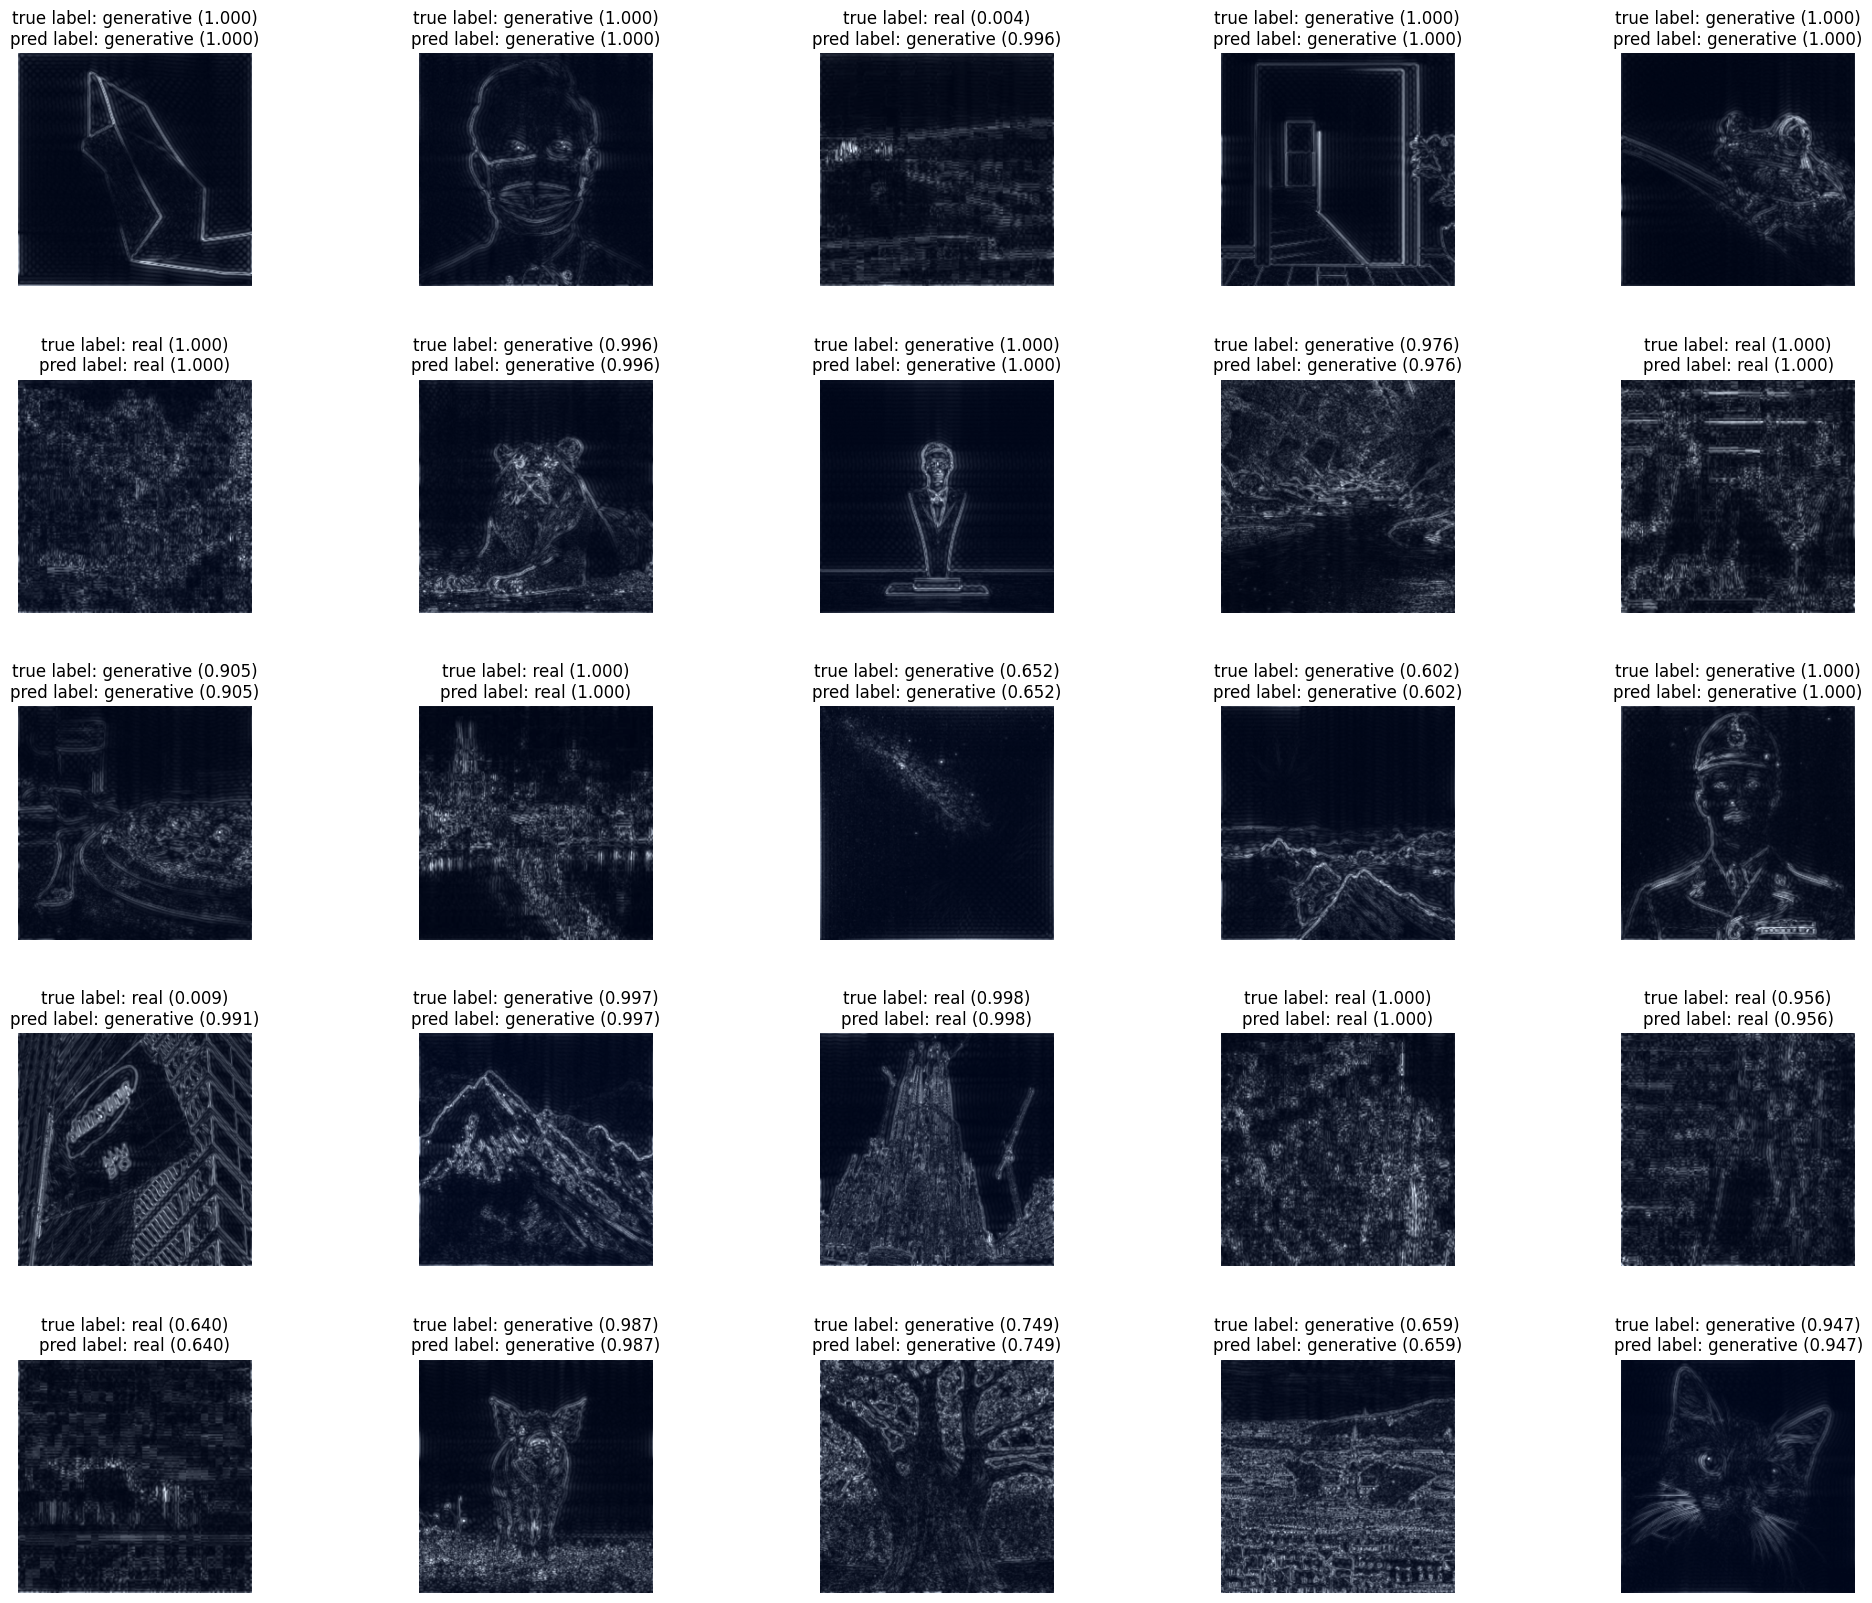

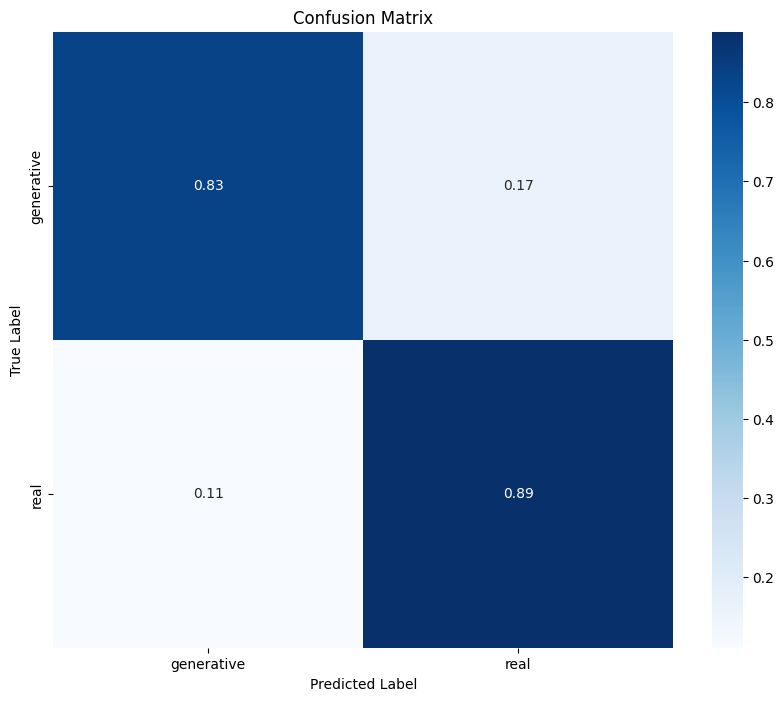

In [ ]:
import random
import matplotlib.pyplot as plt

def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image

def plot_random_predictions(model, test_dataset, device, n_images, normalize=True):
    model.eval()
    fig = plt.figure(figsize=(25, 20))
    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    # 테스트 데이터셋에서 무작위로 이미지 선택
    random_indices = random.sample(range(len(test_dataset)), n_images)
    classes = test_dataset.classes

    for i, idx in enumerate(random_indices):
        ax = fig.add_subplot(rows, cols, i + 1)
        image, true_label = test_dataset[idx]
        image = image.unsqueeze(0).to(device)

        # 예측 수행
        with torch.no_grad():
            y_pred, _ = model(image)
            y_prob = F.softmax(y_pred, dim=-1)
            pred_label = y_prob.argmax(1).item()

        true_prob = y_prob[0][true_label].item()
        correct_prob = y_prob[0][pred_label].item()

        image = image.squeeze(0).permute(1, 2, 0).cpu()
        true_class = classes[true_label]
        pred_class = classes[pred_label]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.numpy())
        ax.set_title(f'true label: {true_class} ({true_prob:.3f})\n' \
                     f'pred label: {pred_class} ({correct_prob:.3f})')
        ax.axis('off')

    fig.subplots_adjust(hspace=0.4)

from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, test_dataset, device):
    model.eval()

    # 테스트 데이터셋에서 예측과 실제 레이블 수집
    y_true = []
    y_pred = []
    classes = test_dataset.classes

    for i in range(len(test_dataset)):
        image, true_label = test_dataset[i]
        image = image.unsqueeze(0).to(device)

        # 예측 수행
        with torch.no_grad():
            y_pred_batch, _ = model(image)
            y_prob = F.softmax(y_pred_batch, dim=-1)
            pred_label = y_prob.argmax(1).item()

        y_true.append(true_label)
        y_pred.append(pred_label)

    # 컨퓨전 매트릭스 계산
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # 컨퓨전 매트릭스 시각화
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



N_IMAGES = 25
plot_random_predictions(model, test_dataset, device, N_IMAGES)

plot_confusion_matrix(model, test_dataset, device)